# Investigación AdaBoost en UCI Covertype

Objetivo: entrenar y evaluar AdaBoost para clasificación multiclase (7 clases) y obtener la precisión (accuracy) final en test.

In [88]:
# Instalación (ejecuta solo si te faltan dependencias)
%pip install ucimlrepo scikit-learn pandas numpy matplotlib seaborn joblib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [89]:
# Imports y configuración
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [90]:
# Carga del dataset Covertype
covertype = fetch_ucirepo(id=31)
df = covertype.data.original.copy()

target_col = 'Cover_Type'
assert target_col in df.columns, 'No se encontró Cover_Type'

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)
feature_names = X.columns.tolist()
X.shape, y.value_counts().sort_index().to_dict()

((581012, 54),
 {1: 211840, 2: 283301, 3: 35754, 4: 2747, 5: 9493, 6: 17367, 7: 20510})

NA X: 0 NA y: 0
Distribución (%) por clase):
Cover_Type
1    36.46
2    48.76
3     6.15
4     0.47
5     1.63
6     2.99
7     3.53
Name: proportion, dtype: float64


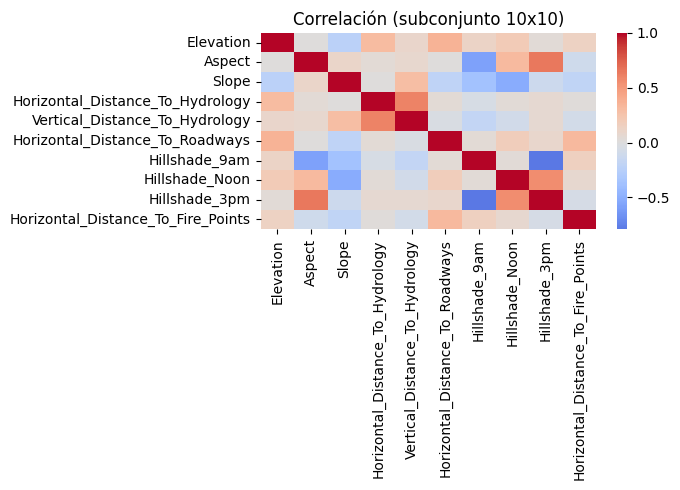

In [91]:
# EDA breve
print('NA X:', X.isna().sum().sum(), 'NA y:', y.isna().sum())
print('Distribución (%) por clase):')
print((y.value_counts(normalize=True).sort_index()*100).round(2))

# Correlación rápida sobre una muestra para no saturar
sample_corr = X.sample(n=min(5000, len(X)), random_state=RANDOM_STATE)
corr = sample_corr.corr(numeric_only=True)
plt.figure(figsize=(7,5))
sns.heatmap(corr.iloc[:10, :10], cmap='coolwarm', center=0)
plt.title('Correlación (subconjunto 10x10)')
plt.tight_layout(); plt.show()

In [92]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(f'Train: {len(X_train):,}  Test: {len(X_test):,}')
print('Distrib train (%):')
print((y_train.value_counts(normalize=True).sort_index()*100).round(2))
print('Distrib test  (%):')
print((y_test.value_counts(normalize=True).sort_index()*100).round(2))

Train: 464,809  Test: 116,203
Distrib train (%):
Cover_Type
1    36.46
2    48.76
3     6.15
4     0.47
5     1.63
6     2.99
7     3.53
Name: proportion, dtype: float64
Distrib test  (%):
Cover_Type
1    36.46
2    48.76
3     6.15
4     0.47
5     1.63
6     2.99
7     3.53
Name: proportion, dtype: float64


In [93]:
# Celda 6: Pipeline AdaBoost (árbol base con class_weight balanceado)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Ponderaciones por clase para el árbol base
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {c: w for c, w in zip(classes, weights)}

# Árbol base poco profundo
base_tree = DecisionTreeClassifier(
        criterion='gini',          # o 'entropy' o 'log_loss' — mide la calidad de las divisiones
        splitter='best',           # 'best' busca la mejor división, 'random' añade aleatoriedad
        max_depth=12,              # ligeramente menor para evitar sobreajuste si el dataset es pequeño
        min_samples_split=10,      # evita divisiones en grupos demasiado pequeños
        min_samples_leaf=5,        # tamaño mínimo de cada hoja, mejora generalización
        max_features=None,         # o 'sqrt' / 'log2' para limitar características por división
        class_weight='balanced',   # útil si hay clases desbalanceadas
        random_state=42            # reproducibilidad
    )

# Compatibilidad de versiones: estimator (>=1.2) vs base_estimator (<1.2)
try:
    ada = AdaBoostClassifier(
        estimator=base_tree,
        n_estimators=200,
        learning_rate=0.5,
        algorithm='SAMME.R',     # puedes cambiar a 'SAMME' si prefieres
        random_state=RANDOM_STATE
    )
except TypeError:
    ada = AdaBoostClassifier(
        base_estimator=base_tree,
        n_estimators=200,
        learning_rate=0.5,
        algorithm='SAMME.R',
        random_state=RANDOM_STATE
    )

pipe = Pipeline([
    ('scaler', 'passthrough'),   # no hace falta escalado para árboles
    ('clf', ada),
])

pipe

Pipeline(steps=[('scaler', 'passthrough'),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=12,
                                                                     min_samples_leaf=5,
                                                                     min_samples_split=10,
                                                                     random_state=42),
                                    learning_rate=0.5, n_estimators=200,
                                    random_state=42))])

In [94]:
# Celda 7 (ALTERNATIVA): HalvingGridSearchCV (successive halving)
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import HalvingGridSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

use_estimator_depth = 'clf__estimator__max_depth' in pipe.get_params().keys()
depth_key = 'clf__estimator__max_depth' if use_estimator_depth else 'clf__base_estimator__max_depth'

# Grid compacto (successive halving probará más barato y “promocionará” lo mejor)
param_grid = {
    'clf__n_estimators': [100, 200, 400],
    'clf__learning_rate': [0.1, 0.3, 0.5],
    'clf__algorithm': ['SAMME'],
    depth_key: [1, 2, 3],
}

halving = HalvingGridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    factor=3,          # mayor factor => menos iteraciones, más agresivo
    resource='n_samples',  # por defecto; va aumentando tamaño de muestra
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=RANDOM_STATE
)

halving.fit(X_train, y_train)
print("Mejores parámetros:", halving.best_params_)
print("Mejor accuracy (CV):", round(halving.best_score_, 4))

best_model = halving.best_estimator_
best_model

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 17215
max_resources_: 464809
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 17215
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensembl

----------
iter: 1
n_candidates: 9
n_resources: 51645
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensembl

----------
iter: 2
n_candidates: 3
n_resources: 154935
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensembl

----------
iter: 3
n_candidates: 1
n_resources: 464805
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/ksius/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Mejores parámetros: {'clf__algorithm': 'SAMME', 'clf__estimator__max_depth': 3, 'clf__learning_rate': 0.5, 'clf__n_estimators': 200}
Mejor accuracy (CV): 0.5261


Pipeline(steps=[('scaler', 'passthrough'),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=3,
                                                                     min_samples_leaf=5,
                                                                     min_samples_split=10,
                                                                     random_state=42),
                                    learning_rate=0.5, n_estimators=200,
                                    random_state=42))])

Accuracy (test): 0.5018
Balanced Accuracy (test): 0.6573
F1-macro (test): 0.4597

Classification report:
              precision    recall  f1-score   support

           1     0.6218    0.4666    0.5331     42368
           2     0.6843    0.4701    0.5573     56661
           3     0.5429    0.6366    0.5860      7151
           4     0.3908    0.8670    0.5388       549
           5     0.0770    0.7620    0.1399      1899
           6     0.3434    0.4921    0.4045      3473
           7     0.3068    0.9071    0.4585      4102

    accuracy                         0.5018    116203
   macro avg     0.4239    0.6573    0.4597    116203
weighted avg     0.6180    0.5018    0.5353    116203



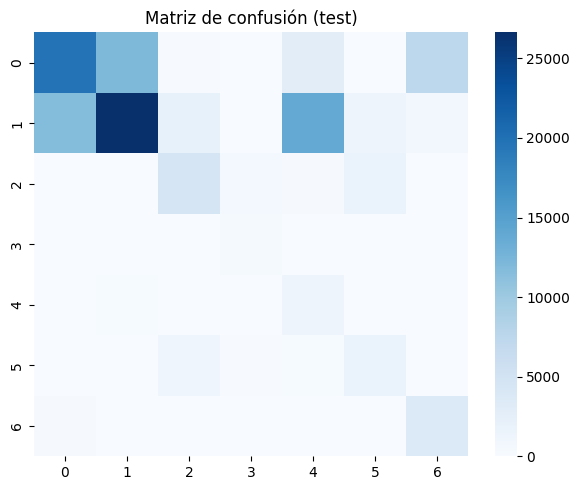

In [95]:
# Celda 8: Evaluación final en test
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')

print("Accuracy (test):", round(accuracy, 4))
print("Balanced Accuracy (test):", round(bal_acc, 4))
print("F1-macro (test):", round(f1m, 4))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='Blues')
plt.title('Matriz de confusión (test)')
plt.tight_layout()
plt.show()

## Conclusión final – AdaBoost en UCI Covertype

- **[desempeño en test]**
  - Accuracy: **0.5018**
  - Balanced Accuracy: **0.6573**
  - F1-macro: **0.4597**

- **[configuración óptima encontrada]**
  - Algoritmo: **SAMME**
  - Árbol base: **DecisionTreeClassifier(max_depth=3, class_weight='balanced')**
  - n_estimators: **200**
  - learning_rate: **0.5**
  - Mejor accuracy en CV: **0.5261**

- **[lectura de resultados]**
  - La brecha entre **Accuracy (0.50)** y **Balanced Accuracy (0.66)** indica efecto del desbalance: el modelo rinde mejor en clases mayoritarias, mientras que las minoritarias requieren atención adicional.
  - El **F1-macro (0.46)** confirma desempeño desigual entre clases; hay margen de mejora en precisión/recobrado de clases menos frecuentes.

- **[implicaciones]**
  - El enfoque con árboles poco profundos + boosting clásico ofrece una base razonable para 7 clases y alta no linealidad, pero no es el estado del arte en este dataset.
  - Para mejorar, conviene:
    - Evaluar `SAMME.R` (mejor calibración de probabilidades).
    - Aumentar ligeramente la capacidad del árbol base (p. ej., `max_depth` 3–5) con control de sobreajuste.
    - Aplicar técnicas para desbalance (ajuste de pesos, undersampling/oversampling).
    - Comparar contra **Random Forest / Gradient Boosting / XGBoost / LightGBM**, que suelen superar a AdaBoost en Covertype.

- **[síntesis]**
  - Con la mejor configuración hallada, AdaBoost logra **50.18%** de acierto global, con **Balanced Accuracy de 65.73%** y **F1-macro de 45.97%**. El modelo captura patrones relevantes, especialmente en clases mayoritarias, pero requiere mejoras para equilibrar el desempeño entre clases y elevar la precisión global.